In [418]:
import math as math
import autograd as Agrad
import autograd.numpy as np 
import autograd.numpy.fft as fft
#import numpy as np
#import numpy.fft as fft
import scipy.optimize
import scipy.stats as st
import scipy.signal as sg
from scipy.integrate import trapz
from scipy.integrate import simps
from photutils import find_peaks
from photutils import detect_threshold
# -- plotting --- 
import matplotlib as mpl 
import matplotlib.pyplot as plt
mpl.rcParams['text.usetex'] = True
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['axes.linewidth'] = 1.5
mpl.rcParams['axes.xmargin'] = 1
mpl.rcParams['xtick.labelsize'] = 'x-large'
mpl.rcParams['xtick.major.size'] = 5
mpl.rcParams['xtick.major.width'] = 1.5
mpl.rcParams['ytick.labelsize'] = 'x-large'
mpl.rcParams['ytick.major.size'] = 5
mpl.rcParams['ytick.major.width'] = 1.5
mpl.rcParams['legend.frameon'] = False
mpl.rcParams.update({'font.size': 22})

np.random.seed(42)

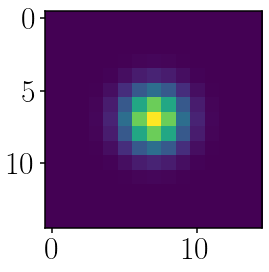

In [419]:
#create global definitions for the data

#create global definitions - this will become a main function later on
np.random.seed(42)
Ndata = 5;
n_grid = 15;
pix_1d = np.linspace(0., 1., n_grid) # pixel gridding
fdensity_true = float(Ndata)/float(n_grid**2); #number density of obj in 1d

#use very small psf and noise
sig_psf = 0.1 # psf width
#sig_noise = 0.01 # noise level
sig_noise = 0.1 # noise level

#create our psf
mid = int(n_grid/2);
x,y = np.meshgrid(pix_1d,pix_1d);
psf = np.exp(-((y-pix_1d[mid])**2 + (x - pix_1d[mid])**2)/2/sig_psf**2); #keep in mind difference between x and y position and indices! Here, you are given indices, but meshgrid is in x-y coords
#fourier transform of psf
psf_k = fft.fft2(psf);
#display psf
plt.imshow(psf);

In [420]:
#create the mock data we will work on
#create coordinate grid
theta_grid = np.linspace(0., 1., n_grid) # gridding of theta (same as pixels)

#create true values - assign to grid
x_true = np.abs(np.random.rand(Ndata)) # location of sources
y_true = np.abs(np.random.rand(Ndata));
#w_true = np.abs(np.random.rand(Ndata))*2 # with intensity betwen 1-2
#sample from power law
w_lin = np.linspace(0.1,2,100);#range of intensities
alpha_true = 2;
w_norm = (w_lin[-1]**(alpha_true+1) - w_lin[0]**(alpha_true+1))/(alpha_true+1); #normalization from integrating
w_func = np.power(w_lin,alpha_true)/w_norm; #pdf to sample intensities, also p1
w_true = w_norm*np.random.choice(w_func,Ndata)
print(w_true);
#true grid needs to be set up with noise
w_true_grid = np.zeros((n_grid,n_grid))
for x,y, w in zip(x_true,y_true, w_true): 
    w_true_grid[np.argmin(np.abs(theta_grid - x)),np.argmin(np.abs(theta_grid - y))] = w
#now create the 'data' by convolving with psf and adding random noise
#by convolution thrm we convolve by inverse tranforming the multiplication of the fft of the data and fft of the psf
noise_grid = np.absolute(sig_noise* np.random.randn(n_grid,n_grid));
data = np.real(fft.ifft2(fft.fft2(w_true_grid)*psf_k)) + noise_grid; #circular conv to work with
data_toshow = sg.convolve(w_true_grid,psf,mode='same') + noise_grid; #linear conv variant for plotting

[0.25303949 1.20555964 0.01420671 3.13182736 0.43107846]


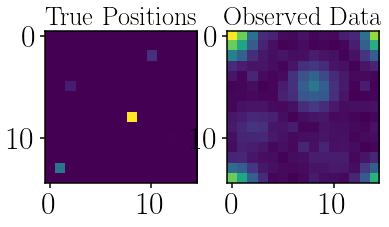

In [421]:
#display the true coordinates and observed data
fig, ax = plt.subplots(1,2)
ax[0].imshow(w_true_grid);
ax[0].set_title('True Positions')
ax[1].imshow(data);
ax[1].set_title('Observed Data')
plt.show();

Notice that the positions of the observed data do not match the true positions. This is due to the periodic boundary conditions of doing convolution, as we do not use padding to adjust.

In [422]:
#In order to minmize w.r.t. complex numbers we embed the complex nummbers into real space with twice the dimensions
#e.g. C -> 2R
#here are our helper functions for this
def real_to_complex(z):      # real vector of length 2n -> complex of length n
    return z[:len(z)//2] + 1j * z[len(z)//2:]

def complex_to_real(z):      # complex vector of length n -> real of length 2n
    return np.real(np.concatenate((np.real(z), np.imag(z))));

#our prior is a lognormal so we make helper functions
norm_mean = -5.; #mean for lognormal
norm_sig = 0.75;

#expects ws, NOT the fourier coefficients ws_k
def lognorm(ws):
    return np.exp(-0.5*(np.log(ws) - norm_mean)**2 /norm_sig**2)/np.sqrt(2*np.pi)/norm_sig/ws;

#derivative of lognorm
def diff_lognorm(ws):
    #taken from: https://iopscience.iop.org/article/10.1088/1742-6596/1338/1/012036/pdf
    df = -1*lognorm(ws)*(1/ws - (np.log(ws)-norm_mean)/ws/norm_sig**2);
    
    return df;

In [423]:
#now we define our loss function (basically log likelihood)
#ws is the fourier coefficients embedded into the reals and flattened to a 1d array

def loss_like(ws_k):
    #gaussian likelihood, assumes ws_k is in complex form and 2d
    conv = np.real(fft.ifft2(ws_k*psf_k)); #convolution of ws with psf
    like_loss = 0.5 * np.sum((conv - data)**2) /sig_noise**2 #gaussian likelihood loss
    
    return like_loss;
def loss_prior(ws,f):
    #prior, assumes ws is real and 2D

    p1 = ws**alpha_true /w_norm;
    prior = np.where(ws<=0.,0.,np.log(lognorm(ws)*(1-f) + f*p1))
    prior_loss = np.sum(prior);
    return prior_loss;

def loss_fn_real(wsp_k,f,epsilon):
    epsilon = epsilon.reshape((n_grid,n_grid));
    wsp_k = wsp_k.reshape((n_grid,n_grid)); #reshape to 2d
    wsp = np.real(fft.ifft2(wsp_k));
    ws = epsilon*np.log(np.exp(wsp/epsilon)+1) #reparametrize from m_prime back to m
    ws_k = fft.fft2(ws);
    return loss_like(ws_k)-loss_prior(ws,f);

def loss_fn(wsp_k,f,epsilon):
    epsilon = epsilon.reshape((n_grid,n_grid));
    wsp_k = real_to_complex(wsp_k); #2*reals -> complex
    wsp_k = wsp_k.reshape((n_grid,n_grid)); #reshape to 2d
    wsp = np.real(fft.ifft2(wsp_k));
    ws = epsilon*np.log(np.exp(wsp/epsilon)+1) #reparametrize from m_prime back to m
    #print(ws);
    ws_k = fft.fft2(ws);
    return loss_like(ws_k) - loss_prior(ws,f);
def loss_like_standalone(wsp_k,f,epsilon):
    epsilon = epsilon.reshape((n_grid,n_grid));
    wsp_k = real_to_complex(wsp_k); #2*reals -> complex
    wsp_k = wsp_k.reshape((n_grid,n_grid)); #reshape to 2d
    wsp = np.real(fft.ifft2(wsp_k));
    ws = epsilon*np.log(np.exp(wsp/epsilon)+1) #reparametrize from m_prime back to m
    ws_k = fft.fft2(ws);
    return loss_like(ws_k);

In [424]:
#analytical gradient or likelihood
def grad_like(wsp,ws,ws_k):
    conv = np.real(fft.ifft2(ws_k*psf_k)); #convolution of ws with psf
    term1 = (conv - data)/n_grid**2 /sig_noise**2 #term thats squared in like (with N in denom)
    grad = np.zeros((n_grid,n_grid),dtype='complex')
    for i in range(0,n_grid):
        for j in range(0,n_grid):        
            #try to modulate by hand
            ft1 = fft.fft2(1/(1+np.exp(-1*wsp/epsilon)));
            ftp = np.roll(ft1,(i,j),axis=(0,1));
            term2 = fft.ifft2(ftp*psf_k);
            grad[i,j] = np.sum(term1*term2);
    grad_real = complex_to_real(np.conj(grad.flatten())); #embed to 2R
    return grad_real; #return 1d array

#analytical gradient of prior
def grad_prior(wsp,ws,ws_k):
    
    param_term = 1/(1+np.exp(-1*wsp/epsilon)) #differentiation term due to parametrization
    #grad = fft.ifft2((-1/ws - (np.log(ws)-norm_mean)/ws/norm_sig**2)*param_term); #version with p1=0
    numerator = (1+(np.log(ws)-norm_mean)/norm_sig**2)*lognorm(ws)/ws + fdensity_true*alpha_true*ws**(alpha_true-1)/w_norm;
    prior = lognorm(ws)*(1-fdensity_true-fdensity_true**2) + fdensity_true*ws**(alpha_true)/w_norm; #prior w/o log
    grad = fft.ifft2(param_term*numerator/prior);
    grad_real = complex_to_real(np.conj(grad.flatten())); #embed to 2R
    return grad_real; #return 1d array

def grad_loss(wsp_k,epsilon):
    wsp_k = real_to_complex(wsp_k); #2*reals -> complex
    wsp_k = wsp_k.reshape((n_grid,n_grid)); #reshape to 2d
    wsp = np.real(fft.ifft2(wsp_k));
    ws = epsilon*np.log(np.exp(wsp/epsilon)+1) #reparametrize from m_prime back to m
    ws_k = fft.fft2(ws);
    
    return grad_like(wsp,ws,ws_k)-grad_prior(wsp,ws,ws_k);

In [425]:
#now we optimize wrt ws_k, the fourier coefficients
f_curr =0.9;
#determine good initial value for eps, take peak value of data.
eps_curr = np.zeros((n_grid,n_grid))+ .02;
#create initial parameters
tt0 = np.zeros((n_grid,n_grid)) + 10; #begin with high uniform mass in each pixel
tt0 = eps_curr*np.log(np.exp(tt0/eps_curr)-1);
tt0_k = fft.fft2(tt0); #take fft
t_ini = complex_to_real(tt0_k.flatten()) #flatten to 1d for scipy and embed in 2R
eps_curr = eps_curr.flatten();
wsp_k_curr = t_ini;

In [426]:
#define autograd gradients
def afunc(th):
    gfunc = Agrad.grad(lambda tt: loss_fn(tt));
    gr = gfunc(th);
    gr[len(gr)//2:] = -1*gr[len(gr)//2:];
    return gr;

def areal(th,f,eps):
    th_comp = real_to_complex(th);
    gfunc = Agrad.holomorphic_grad(lambda tt: loss_fn_real(tt,f,eps));
    grad_comp = gfunc(th_comp);
    grad_real = complex_to_real(np.conj(grad_comp));
    return grad_real;

def aall(wep,f):
    print(np.shape(wep));
    th = wep[:2*n_grid**2];
    eps = wep[2*n_grid**2:];
    th_comp = real_to_complex(th);
    #print(th_comp);
    gfunc = Agrad.holomorphic_grad(lambda tt: loss_fn_real(tt,f,eps));
    grad_comp = gfunc(th_comp);
    grad_real = complex_to_real(np.conj(grad_comp));
    
    gfunc2 = Agrad.grad(lambda ee: loss_fn(th,f,ee));
    grad2 = gfunc(eps);
    return np.concatenate((grad_real,grad2));

def agradf(ws,fs):
    gfunc = Agrad.grad(lambda ff: loss_prior(ws,ff));
    grad = gfunc(fs);
    return grad;

def agradeps(wsp_k,f,eps):
    gfunc = Agrad.grad(lambda ee: loss_like_standalone(wsp_k,f,ee));
    grad = gfunc(eps);
    #print(grad);
    return grad;
def hesseps(wsp_k,f,eps):
    hfunc = Agrad.hessian(lambda ee: loss_like_standalone(wsp_k,f,ee));
    hess = hfunc(eps);
    return hess;

def hfunc(th):
    gfunc = Agrad.hessian(lambda tt: loss_fn(tt));
    gr = gfunc(th);
    #gr[len(gr)//2:,:] = -1*gr[len(gr)//2:,:]
    hess = np.zeros((2*n_grid**2,2*n_grid**2)); #factor of two because of embeding from C -> 2R
    di = [ gr[i][i] for i in range(len(gr)) ]
    #print(di);
    di[len(di)//2:] = -1*di[len(di)//2:];
    np.fill_diagonal(hess,di);
    return hess;    

In [427]:
def optimize_m(wsp_k,f_curr,eps_curr):
    gradfun = lambda tg: areal(tg,f_curr,eps_curr);
    res = scipy.optimize.minimize(lambda tt: loss_fn(tt,f_curr,eps_curr),
        wsp_k, # theta initial
        jac=gradfun,                          
        method='BFGS');
    print('Number of Iterations m');
    print(res['nit']);
    return res['x'];
def combined_loss(wep, f):
    w = wep[:2*n_grid**2];
    eps = wep[2*n_grid**2:];
    return loss_fn(w,f,eps);
def optimize_both(wsp_k,f_curr,eps_curr):
    wep_curr = np.concatenate((wsp_k,eps_curr));
    gradfun = lambda wa: aall(wa,f_curr);
    res = scipy.optimize.minimize(lambda ww: combined_loss(ww,f_curr),
        wep_curr, # theta initial
        jac=gradfun,                          
        method='BFGS');
    print('Number of Iterations m');
    print(res['nit']);
    return res['x'];

def optimize_f(wsp_k,f_curr,epsilon):
    epsilon = epsilon.reshape((n_grid,n_grid));
    wsp_k = real_to_complex(wsp_k); #2*reals -> complex
    wsp_k = wsp_k.reshape((n_grid,n_grid)); #reshape to 2d
    wsp = np.real(fft.ifft2(wsp_k));
    ws = epsilon*np.log(np.exp(wsp/epsilon)+1) #reparametrize from m_prime back to m
    ws = ws.flatten();
    '''
    gradfun = lambda fg: agradf(ws,fg)
    res = scipy.optimize.minimize(lambda tf: loss_prior(ws,f_curr),
        f_curr, # theta initial
        jac=gradfun,                          
        method='L-BFGS-B',
        bounds = [(0,1)]);
    print('Number of Iterations f');
    print(res['nit']);
    return res['x'];
    '''
    #instead let's step f by clipping at 1 sigma (2 was found to be too high)
    fnew = len(ws[2*np.std(ws)<ws-np.average(ws)])/(n_grid**2);
    return fnew;

def optimize_eps(wsp_k,f_curr,eps_curr):
    gradfun = lambda eg: agradeps(wsp_k,f_curr,eps_curr);
    hessfun = lambda eh: hesseps(wsp_k,f_curr,eps_curr);
    res = scipy.optimize.minimize(lambda ee: loss_like_standalone(wsp_k,f_curr,ee),
        eps_curr, # theta initial
        jac=gradfun,
        hess=hessfun,                          
        method='Newton-CG');
    print('Number of Iterations eps');
    print(res['nit']);
    return res['x'];   

def eps_abs(wsp_k,f_curr,eps_curr):
    eps_curr = eps_curr.reshape((n_grid,n_grid))
    wsp_k = real_to_complex(wsp_k); #2*reals -> complex
    wsp_k = wsp_k.reshape((n_grid,n_grid)); #reshape to 2d
    wsp = np.real(fft.ifft2(wsp_k));
    ws = eps_curr*np.log(np.exp(wsp/eps_curr)+1) #reparametrize from m_prime back to m
    return ws.flatten()+0.5;

def eps_grid(wsp_k,f_curr):
    grid = np.linspace(0,100,1000);
    losses = [];
    for eps in grid:
        losses.append(loss_like_standalone(wsp_k,eps));
    print(losses);
    return grid[losses==min(losses)];

In [428]:

wep_prime = optimize_both(wsp_k_curr,f_curr,eps_curr);
wsp_k_curr = wep_prime[:2*n_grid**2];
eps_curr = wep_prime[2*n_grid**2:];
eps_curr = eps_curr.reshape((n_grid,n_grid));
w_final_k = real_to_complex(wsp_k_curr);
w_final_k = w_final_k.reshape((n_grid,n_grid)); #reshape to 2d
w_final = np.real(fft.ifft2(w_final_k));
w_final = eps_curr*np.log(np.exp(w_final/eps_curr)+1);
print('Number of steps')
print(step);
print('Final Loss');
print(loss_fn(wsp_k_curr,f_curr,eps_curr));


(675,)
(675,)
(675,)
(675,)
(675,)
(675,)
(675,)
(675,)
(675,)
(675,)
(675,)
(675,)
(675,)
(675,)
(675,)
(675,)
(675,)
(675,)
(675,)
(675,)
(675,)
(675,)
(675,)
(675,)
(675,)
(675,)
(675,)
(675,)
(675,)
(675,)
(675,)
(675,)
(675,)
(675,)
(675,)
(675,)
(675,)
(675,)
(675,)
(675,)
(675,)
(675,)
(675,)
(675,)
(675,)
(675,)
(675,)
(675,)


/home/moss/anaconda3/envs/astroconda/lib/python3.6/site-packages/autograd/differential_operators.py:66: UserWarning: Input to holomorphic_grad is not complex
  warnings.warn("Input to holomorphic_grad is not complex")
/home/moss/anaconda3/envs/astroconda/lib/python3.6/site-packages/autograd/tracer.py:48: RuntimeWarning: divide by zero encountered in log
  return f_raw(*args, **kwargs)


(675,)
(675,)
(675,)
(675,)
(675,)
(675,)
(675,)
(675,)
(675,)
(675,)
(675,)
(675,)
(675,)
(675,)
(675,)
(675,)
(675,)
(675,)
(675,)
(675,)
(675,)
(675,)
(675,)
(675,)
(675,)
(675,)
(675,)
(675,)
(675,)
(675,)
(675,)
(675,)
(675,)
(675,)
(675,)
(675,)
(675,)
(675,)
(675,)
(675,)
(675,)
(675,)
(675,)
(675,)
(675,)
(675,)
(675,)
(675,)
(675,)
(675,)
(675,)
(675,)
(675,)
(675,)
(675,)
(675,)
(675,)
(675,)
(675,)
(675,)
(675,)
(675,)
(675,)
(675,)
Number of Iterations m
1
Number of steps
14
Final Loss
nan


/home/moss/anaconda3/envs/astroconda/lib/python3.6/site-packages/autograd/differential_operators.py:66: UserWarning: Input to holomorphic_grad is not complex
  warnings.warn("Input to holomorphic_grad is not complex")
/home/moss/anaconda3/envs/astroconda/lib/python3.6/site-packages/autograd/tracer.py:48: RuntimeWarning: divide by zero encountered in log
  return f_raw(*args, **kwargs)
/home/moss/anaconda3/envs/astroconda/lib/python3.6/site-packages/autograd/tracer.py:48: RuntimeWarning: divide by zero encountered in log
  return f_raw(*args, **kwargs)
/home/moss/anaconda3/envs/astroconda/lib/python3.6/site-packages/autograd/differential_operators.py:66: UserWarning: Input to holomorphic_grad is not complex
  warnings.warn("Input to holomorphic_grad is not complex")


In [429]:
'''
#perform alternating optimization
#now we begin optimizing step by step, beginning with M, then f, then alpha
step = 0;
loss_curr = loss_fn(wsp_k_curr,f_curr,eps_curr);
counter = 0;
while(True):
    #start with m
    wsp_k_prime = optimize_m(wsp_k_curr,f_curr,eps_curr)
    print('midstep');
    #step f
    f_prime = optimize_f(wsp_k_prime,f_curr,eps_curr);
    #step eps
    eps_prime = optimize_eps(wsp_k_prime,f_prime,eps_curr)
    
    #print(eps_prime);
    loss_prime = loss_fn(wsp_k_prime,f_prime,eps_prime);
    #eps_prime = eps_grid(wsp_k_prime,f_prime);
    #eps_prime = eps_abs(wsp_k_prime,f_prime,eps_curr);
    #calculate difference for error threshold
    diff_f = abs(f_prime-f_curr);
    diff_eps = abs(eps_prime-eps_curr)
    diff_wsp_k = abs(wsp_k_prime - wsp_k_curr);
    diff_wtot = np.sqrt(diff_wsp_k.dot(diff_wsp_k));
    diff_loss = abs(loss_curr - loss_prime);
    #if np.sqrt(diff_wtot**2 + diff_f**2 + diff_eps**2) < .01 and 1<step:
    #    break;
    if diff_loss < 1 and 1<step:
        counter+=1;
        if counter == 10:
            break;
    else:
        counter = 0;
    #if not passed, then update values and step
    wsp_k_curr = wsp_k_prime;
    f_curr = f_prime;
    eps_curr = eps_prime;
    loss_curr = loss_prime;
    step+=1;
    print('Current Loss');
    print(loss_prime);
#remember this returns the fourier coefficients embeded in the reals
eps_curr = eps_curr.reshape((n_grid,n_grid));
w_final_k = real_to_complex(wsp_k_curr);
w_final_k = w_final_k.reshape((n_grid,n_grid)); #reshape to 2d
w_final = np.real(fft.ifft2(w_final_k));
w_final = eps_curr*np.log(np.exp(w_final/eps_curr)+1);
print('Number of steps')
print(step);
print('Final Loss');
print(loss_fn(wsp_k_curr,f_curr,eps_curr));
'''

"\n#perform alternating optimization\n#now we begin optimizing step by step, beginning with M, then f, then alpha\nstep = 0;\nloss_curr = loss_fn(wsp_k_curr,f_curr,eps_curr);\ncounter = 0;\nwhile(True):\n    #start with m\n    wsp_k_prime = optimize_m(wsp_k_curr,f_curr,eps_curr)\n    print('midstep');\n    #step f\n    f_prime = optimize_f(wsp_k_prime,f_curr,eps_curr);\n    #step eps\n    eps_prime = optimize_eps(wsp_k_prime,f_prime,eps_curr)\n    \n    #print(eps_prime);\n    loss_prime = loss_fn(wsp_k_prime,f_prime,eps_prime);\n    #eps_prime = eps_grid(wsp_k_prime,f_prime);\n    #eps_prime = eps_abs(wsp_k_prime,f_prime,eps_curr);\n    #calculate difference for error threshold\n    diff_f = abs(f_prime-f_curr);\n    diff_eps = abs(eps_prime-eps_curr)\n    diff_wsp_k = abs(wsp_k_prime - wsp_k_curr);\n    diff_wtot = np.sqrt(diff_wsp_k.dot(diff_wsp_k));\n    diff_loss = abs(loss_curr - loss_prime);\n    #if np.sqrt(diff_wtot**2 + diff_f**2 + diff_eps**2) < .01 and 1<step:\n    #    bre

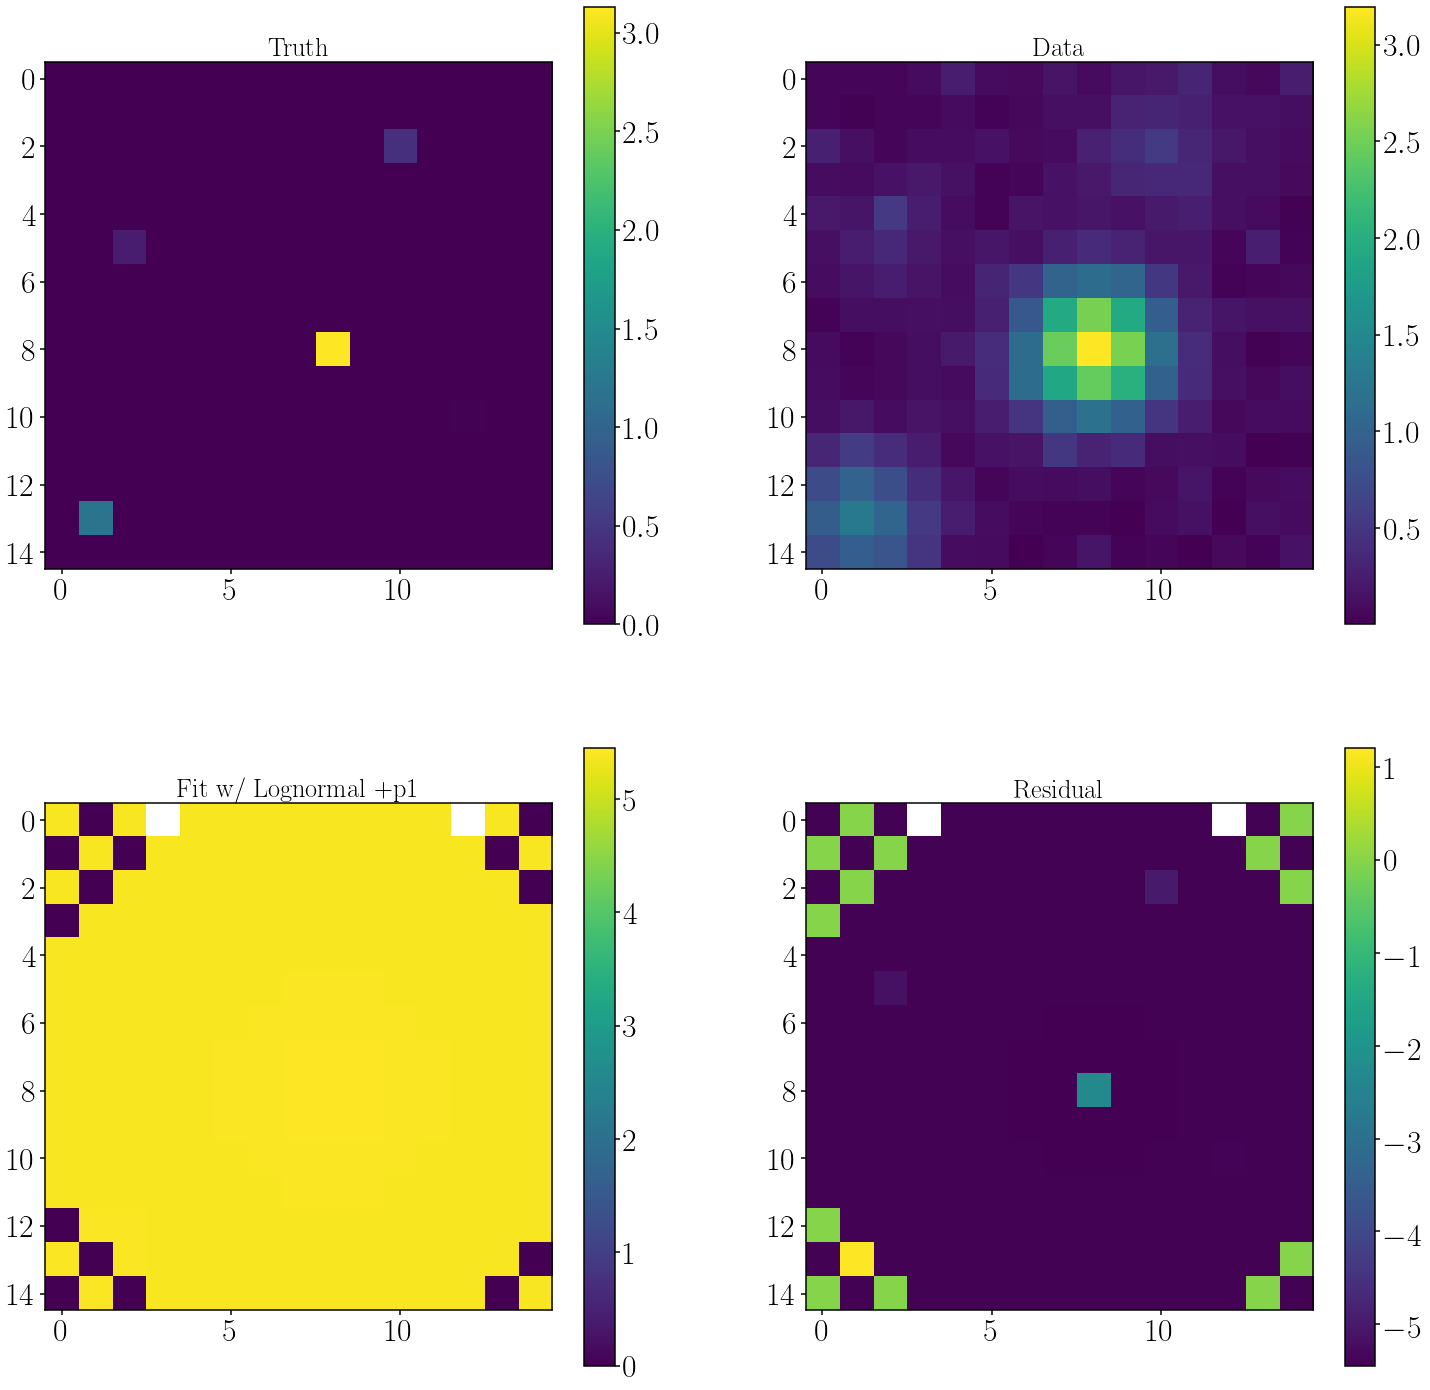

In [430]:
fig, ax = plt.subplots(2,2,figsize=(25,25));
pl0 = ax[0][0].imshow(w_true_grid);
ax[0][0].set_title('Truth')
pl1 = ax[0][1].imshow(data_toshow);
ax[0][1].set_title('Data')
pl2 = ax[1][0].imshow(w_final);
ax[1][0].set_title('Fit w/ Lognormal +p1')
pl3 = ax[1][1].imshow(w_true_grid-w_final);
ax[1][1].set_title('Residual');
fig.colorbar(pl0, ax=ax[0][0])
fig.colorbar(pl1, ax=ax[0][1])
fig.colorbar(pl2, ax=ax[1][0])
fig.colorbar(pl3, ax=ax[1][1])

In [431]:
print(f_curr);
print(eps_curr);

0.9
[[ 2.25997892e-01 -3.03655490e-01  2.16129087e-01  3.29730915e-04
   2.40066033e-02  2.14013644e-02  2.15493327e-02  2.15606137e-02
   2.15606137e-02  2.15493327e-02  2.14013644e-02  2.40066033e-02
   3.29730915e-04  2.16129087e-01 -3.03655490e-01]
 [-3.27253262e-01  4.68178541e-01 -5.95041646e-02  4.84620887e-02
   2.03784015e-02  2.15518981e-02  2.15854015e-02  2.15532478e-02
   2.15606003e-02  2.15317529e-02  2.15127009e-02  1.81328699e-02
   4.08891123e-02 -9.85765119e-02  3.95365128e-01]
 [ 1.65958967e-01 -4.86956443e-02  6.23289223e-02  1.88019267e-02
   2.18862676e-02  2.16953255e-02  2.15669490e-02  2.15541527e-02
   2.15557226e-02  2.15560675e-02  2.13743543e-02  2.21727753e-02
   9.02478235e-03  5.44772111e-02 -1.57347142e-01]
 [-1.92084303e-02  3.78121928e-02  1.65554329e-02  2.12331859e-02
   2.15748072e-02  2.15903775e-02  2.15523469e-02  2.15559438e-02
   2.15554804e-02  2.15576830e-02  2.15904309e-02  2.13785143e-02
   2.22406163e-02  1.28333938e-02  3.37461045e-02]


In [432]:
w_final_k = real_to_complex(wsp_k_curr);
w_final_k = w_final_k.reshape((n_grid,n_grid)); #reshape to 2d
w_final = np.real(fft.ifft2(w_final_k));
w_final = eps_curr*np.log(np.exp(w_final/eps_curr)+1);
print(w_final);

[[ 5.40518765e+00 -5.61531247e-09  5.40544179e+00             inf
   5.39788747e+00  5.39537378e+00  5.39442289e+00  5.39459172e+00
   5.39545040e+00  5.39655888e+00  5.39729716e+00  5.39740027e+00
              inf  5.39887045e+00 -5.70983283e-09]
 [-2.23122034e-08  5.40095988e+00 -0.00000000e+00  5.39839936e+00
   5.39619430e+00  5.39473009e+00  5.39441381e+00  5.39521857e+00
   5.39683490e+00  5.39861757e+00  5.39965107e+00  5.39941300e+00
   5.39844199e+00 -0.00000000e+00  5.39861819e+00]
 [ 5.39719604e+00 -0.00000000e+00  5.39757754e+00  5.39669859e+00
   5.39546466e+00  5.39458772e+00  5.39465021e+00  5.39587022e+00
   5.39794960e+00  5.40005786e+00  5.40110504e+00  5.40052253e+00
   5.39888270e+00  5.39741513e+00 -2.09628504e-16]
 [-0.00000000e+00  5.39690675e+00  5.39708188e+00  5.39661425e+00
   5.39575149e+00  5.39517691e+00  5.39556327e+00  5.39707245e+00
   5.39918897e+00  5.40094420e+00  5.40138822e+00  5.40028169e+00
   5.39837476e+00  5.39680669e+00  5.39620003e+00]
 [ 5